## Packages

In [10]:
#pip install datasets
#pip install --upgrade accelerate
#pip install torch torchvision
#pip install transformers[torch]

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from functools import partial

import transformers
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig, AdamW

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, roc_curve, f1_score
import accelerate

/opt/anaconda3/envs/stock/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data


In [3]:
raw = pd.read_csv('earningscall_final.csv', encoding='utf-8', names=['summary','label','score','Generated_Text'])
raw['label'].replace({'neutral':'Neutral', 'positive':'Positive', 'negative': 'Negative'}, inplace=True)
raw = raw.drop(raw.index[0])
raw2 = raw.copy()
raw2['label'].replace({'Neutral':0, 'Positive':1, 'Negative':2}, inplace=True)
raw2 = raw2[['summary','label','score','Generated_Text']]
seed = 2024
raw2

/var/folders/7w/846qc9yj1yl9_3gczch751xm0000gn/T/ipykernel_58506/737291120.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw['label'].replace({'neutral':'Neutral', 'positive':'Positive', 'negative': 'Negative'}, inplace=True)
/var/folders/7w/846qc9yj1yl9_3gczch751xm0000gn/T/ipykernel_58506/737291120.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

,summary,label,score,Generated_Text
1,The vast majority of the Tesla production syst...,2,0.673865944,Automotive
2,"In the third quarter, it will -- I think there...",1,0.787874013,Automotive
3,The takt -- the number you're referring to is ...,0,0.773035198,Automotive
4,Deepak Ahuja: Every data point suggests that w...,0,0.554323912,Energy Generation and Storage
5,Elon R. Musk: I feel very confident about our ...,1,0.685583651,Automotive
...,...,...,...,...
506,Q1 volumes are much higher than what youwould ...,0,0.600599229,Automotive
507,The most fundamental difference is thinking ab...,0,0.579746559,Automotive
508,Elon Musk: There's really -- there are only 2 ...,0,0.632685572,Automotive
509,"I can see a path where we get to, say, 600,000...",1,0.632164747,Automotive


In [9]:
raw2_new = raw2.drop(columns=['score','Generated_Text'])
#raw2_new['label'] = raw2_new['label'].astype(str)
raw2_new

,summary,label
1,The vast majority of the Tesla production syst...,2
2,"In the third quarter, it will -- I think there...",1
3,The takt -- the number you're referring to is ...,0
4,Deepak Ahuja: Every data point suggests that w...,0
5,Elon R. Musk: I feel very confident about our ...,1
...,...,...
506,Q1 volumes are much higher than what youwould ...,0
507,The most fundamental difference is thinking ab...,0
508,Elon Musk: There's really -- there are only 2 ...,0
509,"I can see a path where we get to, say, 600,000...",1


In [10]:
df_train, df_test, = train_test_split(raw2_new, stratify=raw2_new['label'], test_size=0.1, random_state=seed)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=seed)
print(df_train.shape, df_test.shape, df_val.shape)

(413, 2) (51, 2) (46, 2)


In [11]:
val_set = df_val.copy()
test_set = df_test.copy()
test_set = pd.concat([test_set, val_set], axis=0) # 把test和val concat起來
test_set.reset_index(inplace=True, drop = True)
test_set['label'].replace({0:'Neutral', 1:'Positive', 2:'Negative'}, inplace=True)
print(test_set.shape)

(97, 2)


/var/folders/7w/846qc9yj1yl9_3gczch751xm0000gn/T/ipykernel_58506/3218815863.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_set['label'].replace({0:'Neutral', 1:'Positive', 2:'Negative'}, inplace=True)


## Fine-tuned BERT Model

### I. Fine-tuning Process

In [13]:
#bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
bert = BertForSequenceClassification.from_pretrained('google-bert/bert-large-uncased', num_labels=3)
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: senti_tokenizer(e['summary'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_val = dataset_val.map(lambda e: senti_tokenizer(e['summary'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_test = dataset_test.map(lambda e: senti_tokenizer(e['summary'], truncation=True, padding='max_length' , max_length=512), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 51/51 [00:00<00:00, 353.67 examples/s]


In [4]:
dataset_train

NameError: name 'dataset_train' is not defined

In [2]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score' : f1_score(predictions, labels, average='micro')}

args = TrainingArguments(
        output_dir='temp/',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=5,
        per_device_eval_batch_size=5,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_score',
)
'''
args = TrainingArguments(
    logging_steps = 10,
    warmup_steps = 10,
    weight_decay = 0.01,
    learning_rate = 5e-5,
    num_train_epochs = 30,
    logging_dir = './logs',
    output_dir = './results',
    evaluation_strategy = "steps",
    load_best_model_at_end = True,
    per_device_eval_batch_size = 128,
    per_device_train_batch_size = 128,
)
'''

trainer = Trainer(
        model=bert,                # the instantiated Transformers model to be trained
        args=args,                 # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,           # evaluation dataset
        compute_metrics=compute_metrics
)


NameError: name 'TrainingArguments' is not defined

In [1]:
trainer.train()

NameError: name 'trainer' is not defined

In [ ]:
bert.eval()
trainer.predict(dataset_test).metrics

{'test_loss': 0.23832163214683533,
 'test_f1_score': 0.9272727272727272,
 'test_runtime': 1.7253,
 'test_samples_per_second': 31.878,
 'test_steps_per_second': 6.376}

In [ ]:

trainer.save_model('BERT_fine_tuned_2')

### II. Evaluate the Fine-tuned BERT Model

In [ ]:
tuned_bert_model = BertForSequenceClassification.from_pretrained('BERT_fine_tuned_1', id2label={0: 'Neutral', 1: 'Positive', 2: 'Negative'})
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tuned_bert_model.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [ ]:
neutral = list()
positive = list()
negative = list()
for i in range(len(test_set)):
  inputs = senti_tokenizer(test_set.iloc[i, 0], padding=True, truncation=True, max_length=512, return_tensors='pt') #tokenize text to be sent to model
  outputs = tuned_bert_model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  neutral.append(predictions[0][0].tolist())
  positive.append(predictions[0][1].tolist())
  negative.append(predictions[0][2].tolist())

In [ ]:
df_array = np.array(test_set)
df_list = list(df_array[:, 0])
table = {'News_Headline':df_list, "Positive":positive, "Negative":negative, "Neutral":neutral}
result_ft_BERT = pd.DataFrame(table, columns = ["News_Headline", "Positive", "Negative", "Neutral"])
result_ft_BERT['Prediction'] = result_ft_BERT[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)
result_ft_BERT['label'] = test_set['label'].copy()
result_ft_BERT

,News_Headline,Positive,Negative,Neutral,Prediction,label
0,The information in the transcripts are provide...,0.065585,0.040744,0.893671,Neutral,Neutral
1,If you look really long-term what's the total ...,0.045260,0.028274,0.926466,Neutral,Neutral
2,production line is humming. And our suppliers...,0.311479,0.075012,0.613508,Neutral,Negative
3,"This year, we think that we'll be able to allo...",0.811725,0.035936,0.152340,Positive,Positive
4,SolarCity was actually a cash generator for th...,0.044840,0.039258,0.915902,Neutral,Neutral
...,...,...,...,...,...,...
99,"Elon R. Musk CEO, Product Architect, Chairman ...",0.722190,0.044549,0.233261,Positive,Positive
100,The focus is really massively on safety of exi...,0.706620,0.040447,0.252933,Positive,Neutral
101,"The rate card for California, Tesla Insurance ...",0.268405,0.045536,0.686060,Neutral,Neutral
102,Our next question comes from the line of David...,0.062586,0.030513,0.906901,Neutral,Neutral


In [ ]:
print(classification_report(result_ft_BERT['label'], result_ft_BERT['Prediction']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         3
     Neutral       0.89      0.95      0.92        61
    Positive       0.90      0.88      0.89        40

    accuracy                           0.89       104
   macro avg       0.60      0.61      0.60       104
weighted avg       0.87      0.89      0.88       104



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    :param confusion_matrix: numpy.ndarray, The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
                             Similarly, constructed nd.Arrays can also be used.
    :param class_names: An ordered list of class names, in the order they index the given confusion matrix.
    :param figsize: tuple, A 2-long tuple, the first value determining the horizontal size of the output figure, the second
                    determining the vertical size. Defaults to (10,7).
    :param fontsize: int, Font size for axes labels. Defaults to 14.
    :return: matplotlib.figure.Figure, The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

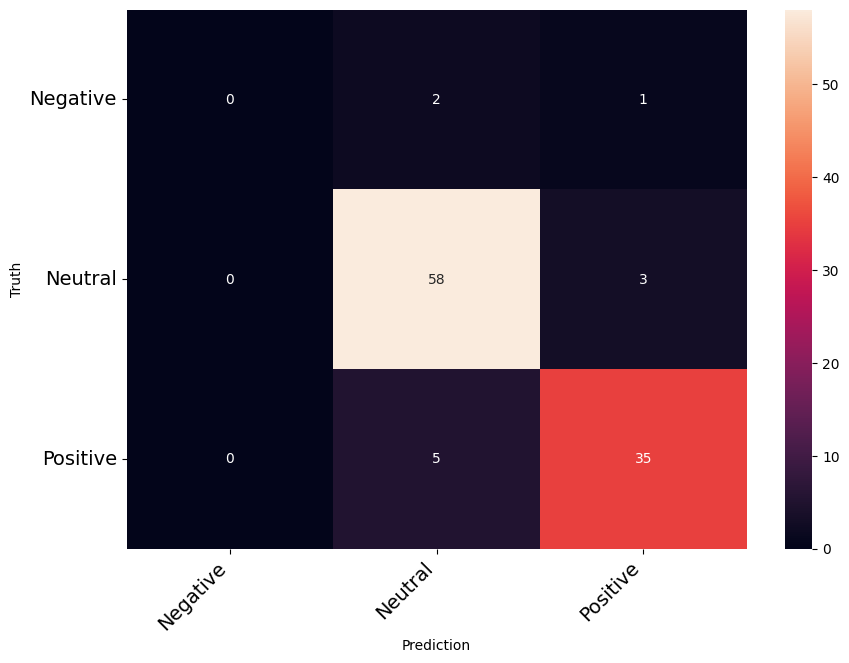

In [ ]:
print_confusion_matrix(confusion_matrix(result_ft_BERT['label'], result_ft_BERT['Prediction']), ['Negative', 'Neutral', 'Positive'])

In [ ]:
torch.cuda.empty_cache() # 這一步很重要